<h2>Class Assignment Week 8<br>
Sherin Alvinia Yonatan - 0706022310013

<h2>PRISM Algorithm

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification, make_blobs, fetch_openml
import sklearn.datasets as datasets
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,f1_score
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype


class PrismRules:
    def __init__(self, min_coverage=10, min_prob=0.75, nbins=3, verbose=0):
        """
        Class to generate PRISM rules for a supplied dataset.

        :param min_coverage: The minimum number of rows each rule must cover.
        :param min_prob: The minimum probability for each rule. The target class must be the target value in the
            remaining rows (the rows not covered by previous rules) with at least this probability.
        :param nbins: The number of bins each numeric column is divided into.
        :param verbose: If 0, no output is produced other than the induced rules. If 1, progress indication is
            presented as each rule is induced.
        """

        self.min_coverage = min_coverage
        self.min_prob = min_prob
        self.nbins = nbins
        self.bin_ranges = {}
        self.verbose = verbose
        self.default_target = None
        self.predict_dict = {}
        self.target_column = ""

        # For improved performance, integer values are used for each value. This dictionary maps the integer codes
        # to the original values, and is used to display the rules and target values. Where the column is numeric,
        # this maps to the bin label.
        self.int_to_values_map = {}

    def __get_next_term(self, df, target_col, target_val, cols_exclude_list):
        """
        Get the next term (a column-value pair) for the current rule.

        :param df: The dataframe for the current rule. This is the set of rows matching the rule so far.
        :param target_col: Target column
        :param target_val: The current target value within the target column
        :param cols_exclude_list: Columns for which we already have terms for this rule.
        :return: a single term in tuple format, with a column name and value from that column, along with the
            probability and coverage (frequency) of the rule on the remaining rows.
        """

        max_prob = -1
        # In the event of ties with respect to probability, we take the term with the greatest frequency
        max_prob_freq = 0
        term = None
        for col_name in df.drop(columns=[target_col]).columns:
            if col_name in cols_exclude_list:
                continue
            for val in df[col_name].unique():
                sub_df_1 = df[df[col_name] == val]
                sub_df_2 = df[(df[col_name] == val) & (df[target_col] == target_val)]
                prob = len(sub_df_2) / len(sub_df_1)
                freq = len(sub_df_2)
                if freq < self.min_coverage:
                    continue
                if (prob > max_prob) or ((prob == max_prob) and (freq > max_prob_freq)):
                    max_prob = prob
                    max_prob_freq = freq
                    term = (col_name, val, prob, freq)
        return term

    def __get_next_rule(self, df_rule, target_col, target_val):
        """
        Given a specified target_val in the target_col, find the first or next rule. If not the first, the dataframe
        should just contain rows not covered by the previous rules for this target value.

        :param df_rule: the full original dataframe, minus the rows covered by other rules for the current target
        :param target_col: the target column
        :param target_val: the target value
        :return: a list of terms for the new rule, and a dataframe with the rows for this rule
        """

        terms_list = []
        cols_exclude_list = []  # Do not create terms for the same feature in the same rule
        df = df_rule.copy()
        target_val_remaining = df[target_col].tolist().count(target_val)
        len_df = len(df)
        while target_val_remaining < len_df:
            term = self.__get_next_term(df, target_col, target_val, cols_exclude_list)
            if term is None:
                break
            col, val, prob, freq = term
            cols_exclude_list.append(col)
            if len(cols_exclude_list) == (len(df.columns) - 1):
                break
            df = df[(df[col] == val)]
            terms_list.append((term, df))
            target_val_remaining = df[target_col].tolist().count(target_val)
            len_df = len(df)

        # Check the terms list for the optimal set of terms, which is the set with the highest probability of the
        # target class given the terms.
        max_prob = 0
        max_prob_idx = -1
        max_prob_df = None
        for term_idx, term in enumerate(terms_list):
            if term[0][2] > max_prob:
                max_prob = term[0][2]
                max_prob_idx = term_idx
                max_prob_df = term[1]
        optimal_terms_list = terms_list[:max_prob_idx + 1]
        optimal_terms_list = [x for x, y in optimal_terms_list]

        if max_prob < self.min_prob:
            return None, None

        # Convert the integer codes used in the dataframe to the original values for the relevant column
        formatted_terms = []
        for t in optimal_terms_list:
            if t[1] == "NONE":
                formatted_terms.append(t)
            else:
                formatted_terms.append((t[0], self.int_to_values_map[t[0]][t[1]], t[2], t[3]))

        return formatted_terms, max_prob_df

    def __get_rules_for_target_val(self, df_full, target_col, target_val):
        """
        Get the full set of rules for the specified value in the target column
        :param df_full:
        :param target_col:  Name of target column
        :param target_val:  Value in the target column for which this execution of this function generates rules.
        :return: array of strings.
        """

        rules_for_val = []
        num_rows_curr_target = df_full[target_col].tolist().count(target_val)
        df = df_full.copy()  # Create a temporary dataframe that shrinks as the rules are formed
        is_first_rule = True
        target_val_remaining = df[target_col].tolist().count(target_val)
        while target_val_remaining > self.min_coverage:
            if self.verbose:
                print(f"  Determining next rule. {target_val_remaining:,} rows remaining for target class")
            num_rows_curr_target_remaining = df[target_col].tolist().count(target_val)
            terms_list, rule_df = self.__get_next_rule(df, target_col, target_val)
            if not terms_list:
                break

            if target_val in self.predict_dict:
                self.predict_dict[target_val].append(terms_list)
            else:
                self.predict_dict[target_val] = [terms_list]

            # Add a rule in string format representing the list of terms returned
            rule_str = ""
            for term in terms_list:
                rule_str += str(term[0]) + " = " + str(term[1]) + " AND "
            rule_str = rule_str[:-5]  # Remove the trailing "AND"
            num_matching_target = rule_df[target_col].tolist().count(target_val)
            rule_str += "\n   Support:  "
            if is_first_rule:
                rule_str += f"the target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} rows matching the rule "
                rule_str += "\n   Coverage: "
                rule_str += f"the rule matches: {num_matching_target} out of {num_rows_curr_target} rows "
                rule_str += f"for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
            else:
                rule_str += f"The target has value: '{self.int_to_values_map[target_col][target_val]}' for "
                rule_str += f"{terms_list[-1][2] * 100:.3f}% of the {num_matching_target} remaining rows matching the "
                rule_str += "rule"
                rule_str += "\n   Coverage: "
                rule_str += f"The rule matches: {num_matching_target} out of {num_rows_curr_target_remaining} rows "
                rule_str += f"remaining for target value: '{self.int_to_values_map[target_col][target_val]}'. This is:"
                rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target_remaining):.3f}% of "
                rule_str += f"remaining rows for target value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / num_rows_curr_target):.3f}% of total rows for target "
            rule_str += f"value: '{self.int_to_values_map[target_col][target_val]}'"
            rule_str += f"\n      {(num_matching_target * 100.0 / len(df_full)):.3f}% of total rows in data"
            rules_for_val.append(rule_str)
            is_first_rule = False

            # Remove all rows for this rule
            df = df.loc[list(set(df.index) - set(rule_df.index))]
            target_val_remaining = df[target_col].tolist().count(target_val)
        return rules_for_val

    def __display_rules(self, df, target_col, rules_dict, display_stats):
        for target_val in rules_dict:
            print()
            print('........................................................................')
            print(f"Target: {self.int_to_values_map[target_col][target_val]}")
            print('........................................................................')
            if len(rules_dict[target_val]) == 0 and display_stats:
                print((f"  No rules imputed for target value {self.int_to_values_map[target_col][target_val]}. There "
                       f"are {df[target_col].tolist().count(target_val)} rows for this class."))
            for r in rules_dict[target_val]:
                if display_stats:
                    print(r)
                else:
                    print(r.split("\n")[0])

    def get_prism_rules(self, df, target_col, display_stats=True):
        """
        Given a dataframe with a specified target column, find a set of rules that describe the patterns associated
        with the target column. The rules are displayed in a formatted form.

        :param df: pandas dataframe. Must include the target column.
        :param target_col: Name of the target column
        :param display_stats: If True, the support and coverage for each rule will be displayed
        :return: array of strings, with each element of the array representing one rule.
        """

        # PRISM requires all columns be categorical, so bin any numeric features, including the target column if
        # necessary.
        new_vals_dict = {}
        for col_name in df.columns:
            if is_numeric_dtype(df[col_name]) and (df[col_name].nunique() > 10):
                try:
                    if self.nbins == 3:
                        vals = ['Low', "Med", 'High']
                        bin_ids, bin_ranges = pd.qcut(df[col_name], 3, labels=vals, retbins=True)
                    else:
                        vals = [f"Bin_{x}" for x in range(self.nbins)]
                        bin_ids, bin_ranges = pd.qcut(df[col_name], self.nbins, labels=vals, retbins=True)
                    self.bin_ranges[col_name] = bin_ranges
                    vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                    int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                    new_vals_dict[col_name] = bin_ids.map(vals_to_int_map)
                    self.int_to_values_map[col_name] = int_to_vals_map
                except:
                    # The qcut() method may fail if the data is sufficiently skewed, and the bins are non-unique, In
                    # this case we do not include the column in the model.
                    pass
            else:
                vals = df[col_name].unique()
                vals_to_int_map = {x: y for x, y in zip(vals, range(len(vals)))}
                int_to_vals_map = {y: x for x, y in zip(vals, range(len(vals)))}
                new_vals_dict[col_name] = df[col_name].map(vals_to_int_map)
                self.int_to_values_map[col_name] = int_to_vals_map
        df = pd.DataFrame(new_vals_dict)

        # Remove any columns with only 1 unique value
        drop_cols = []
        for col_name in df.columns:
            if df[col_name].nunique() < 2:
                drop_cols.append(col_name)
        df = df.drop(columns=drop_cols)

        # Fill any NaN and None values
        for col_name in df.columns:
            if df[col_name].dtype.name == "category":
                df[col_name] = df[col_name].cat.add_categories("NONE").fillna("NONE")
            else:
                df[col_name] = df[col_name].fillna("NULL")

        # Loop through each value in the target column and find the set of rules for this value
        target_vals = sorted(df[target_col].unique())
        if self.verbose:
            print(f"Determining rules for each of {len(target_vals)} target classes:")
        rules_dict = {}
        for target_val in target_vals:
            if self.verbose >= 1:
                print(f"Determining rules for target class: {self.int_to_values_map[target_col][target_val]}")
            rules_dict[target_val] = self.__get_rules_for_target_val(df, target_col, target_val)

        self.__display_rules(df, target_col, rules_dict, display_stats)

        self.default_target = df[target_col].mode().values[0]
        self.target_column = target_col

        return rules_dict

    def predict(self, X_in, leave_unknown=False):
        X = X_in.copy()
        X = X.reset_index(drop=True)
        if leave_unknown:
            ret = ["NO PREDICTION"]*len(X)
        else:
            ret = [self.default_target]*len(X)
        is_set = [False]*len(X)

        for col_name in X.columns:
            if col_name not in self.bin_ranges:
                continue
            bin_ranges = self.bin_ranges[col_name]
            for i in range(len(X)):
                v = X.loc[i, col_name]
                for bin_idx, bin_limit in enumerate(bin_ranges):
                    if v < bin_limit:
                        X.loc[i, col_name] = bin_idx - 1
                        break
            if col_name in self.int_to_values_map:
                X[col_name] = X[col_name].map(self.int_to_values_map[col_name])

        for i in range(len(X)):
            row = X.iloc[i]
            found_rule = False
            for key in self.predict_dict.keys():
                rules = self.predict_dict[key]
                for rule in rules:
                    all_terms_true = True
                    for term in rule:
                        term_feature_name = term[0]
                        term_value = term[1]
                        if row[term_feature_name] != term_value:
                            all_terms_true = False
                            break
                    if all_terms_true:
                        ret[i] = key
                        is_set[i] = True
                        found_rule = True
                        break
                if found_rule:
                    break
        ret = pd.Series(ret).map(self.int_to_values_map[self.target_column])
        if leave_unknown:
            ret = ret.fillna("NO PREDICTION")
            ret = ret.astype(str)
        return ret

    def get_bin_ranges(self):
        if self.bin_ranges is None:
            print("No columns were binned.")
        else:
            return self.bin_ranges


<h2>Data Preparation & EDA

In [2]:
url = "https://raw.githubusercontent.com/NathaliaMinoque/datasets/refs/heads/main/wine_data.csv"
df = pd.read_csv(url)
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
0,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
1,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.20,0.61,1.60,560.0,2
2,12.16,1.61,2.31,22.8,90.0,1.78,1.69,0.43,1.56,2.45,1.33,2.26,495.0,1
3,13.07,1.50,2.10,15.5,98.0,2.40,2.64,0.28,1.37,3.70,1.18,2.69,1020.0,0
4,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  Y    

In [5]:
df.shape

(178, 14)

In [6]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Y
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


In [7]:
df.isnull().sum()

,0
alcohol,0
malic_acid,0
ash,0
alcalinity_of_ash,0
magnesium,0
total_phenols,0
flavanoids,0
nonflavanoid_phenols,0
proanthocyanins,0
color_intensity,0


Because there is no null row and all the data is already clean and bin, so i dont perform data cleaning and binning/discretization.

In [8]:
df = df.sample(n=len(df)) # Shuffle the rows
print("Number of rows:", len(df))

Number of rows: 178


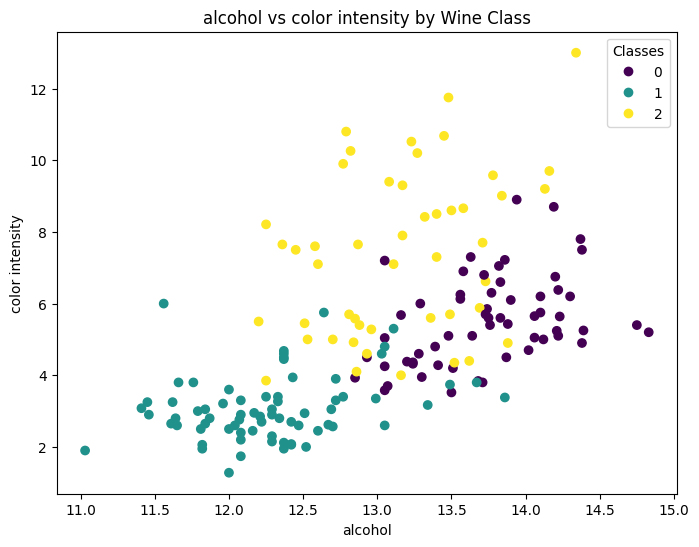

In [11]:
# Visualization 1
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['alcohol'], df['color_intensity'], c=df['Y'], cmap='viridis')
plt.xlabel('alcohol')
plt.ylabel('color intensity')
plt.title('alcohol vs color intensity by Wine Class')
legend = plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

The scatter plot illustrates the relationship between alcohol content and color intensity across the three wine classes in the dataset. A positive relationship can be observed, where wines with higher alcohol levels generally exhibit higher color intensity values. Class 0 wines tend to cluster around lower alcohol concentrations (approximately 11–13%) and lower color intensity (around 2–6), indicating lighter-bodied varieties. Class 1 wines occupy the middle range for both variables, with alcohol content between 12.5–14% and color intensity ranging from 4–9. In contrast, Class 2 wines are predominantly associated with higher alcohol levels (13–15%) and greater color intensity (7–13), suggesting richer and more robust compositions. This distribution indicates that alcohol content and color intensity may serve as useful distinguishing features among the three wine classes.

The scatter plot shows that wines with higher alcohol content generally have higher color intensity. Class 0 wines mostly have lower alcohol and lighter color intensity, while Class 2 wines tend to have higher alcohol and deeper color intensity. Class 1 wines fall in between the two. This pattern suggests that both alcohol level and color intensity can help distinguish between different wine classes.

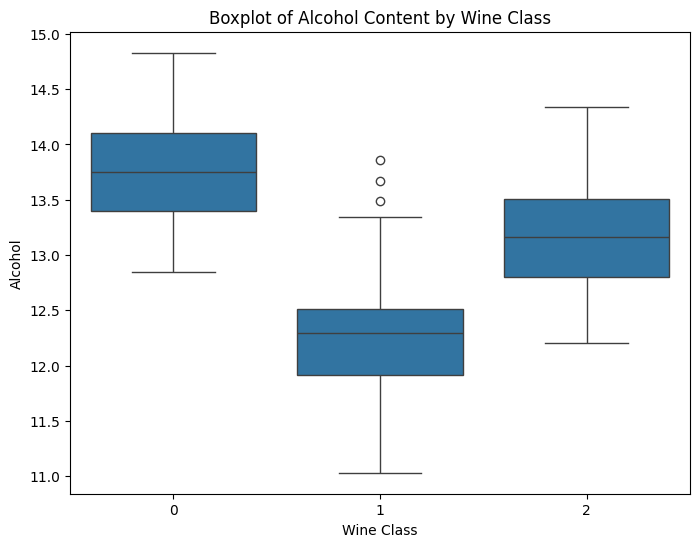

In [12]:
# Visualization 2
import seaborn as sns

plt.figure(figsize=(8,6))
sns.boxplot(x='Y', y='alcohol', data=df)
plt.title('Boxplot of Alcohol Content by Wine Class')
plt.xlabel('Wine Class')
plt.ylabel('Alcohol')
plt.show()


The boxplot shows that alcohol content varies noticeably among the three wine classes. Class 0 wines generally have the highest alcohol levels, with a median around 13.8–14%, while Class 1 wines have the lowest median alcohol content (around 12.3%), and a few lower outliers. Class 2 wines fall in between, with a moderate alcohol range and fewer extreme values. This pattern indicates that alcohol concentration is a distinguishing feature among the wine classes, particularly between Class 0 and Class 1.

The boxplot indicates that alcohol content differs noticeably among wine classes. Class 0 wines have the highest alcohol levels, Class 1 wines have the lowest, and Class 2 wines fall in between. This shows a clear difference in alcohol concentration across the three wine types.

<h2>Apply PRISM Algorithm

In [14]:
prism = PrismRules()
_ = prism.get_prism_rules(df.head(124), 'Y')


........................................................................
Target: 2
........................................................................
flavanoids = Low AND color_intensity = Med
   Support:  the target has value: '2' for 100.000% of the 12 rows matching the rule 
   Coverage: the rule matches: 12 out of 32 rows for target value: '2'. This is:
      37.500% of total rows for target value: '2'
      9.677% of total rows in data
od280/od315_of_diluted_wines = Low AND color_intensity = High AND hue = Low
   Support:  The target has value: '2' for 100.000% of the 20 remaining rows matching the rule
   Coverage: The rule matches: 20 out of 20 rows remaining for target value: '2'. This is:
      100.000% of remaining rows for target value: '2'
      62.500% of total rows for target value: '2'
      16.129% of total rows in data

........................................................................
Target: 0
.............................................................

- I use 70% (124 data) for training and 30% (54 data) for testing.

Target: Class 2<br>
Rule 1<br>
If flavanoids = Low AND color_intensity = Medium -> Class 2
- This rule shows that wines with low flavanoid levels and medium color intensity are very likely to belong to Class 2.It is highly specific (100% support — no errors among those 12 wines) but moderately general (covers only 37.5% of Class 2 wines).<br><br>

Rule 2<br>
If od280/od315_of_diluted_wines = Low AND color_intensity = High AND hue = Low -> Class 2
- This rule indicates that wines with low od280/od315 ratio, high color intensity, and low hue all belong to Class 2. It is a very strong rule — perfectly accurate (100% support) and covers all remaining Class 2 samples.
These wines likely have deep color but weaker dilution and hue, distinguishing them clearly from other classes.



Target: Class 0<br>
Rule 3<br>
If proline = High AND flavanoids = High -> Class 0
- This rule suggests that wines with high proline and high flavanoid content tend to belong to Class 0.
The rule has strong support and high coverage, meaning most Class 0 wines share these characteristics (they are likely richer in amino acids and antioxidants, typically associated with higher-quality wines).<br>


Target: Class 1<br>
Rule 4<br>
If color_intensity = Low AND alcohol = Low -> Class 1
- This rule indicates that wines with low color intensity and low alcohol levels are strongly associated with Class 1. It is both accurate (100% support) and covers the majority (73%) of Class 1 samples, showing that these wines are generally lighter and less potent than others.

<h2>Model Evaluation

In [15]:
prism = PrismRules()
_ = prism.get_prism_rules(df.tail(54), 'Y')


........................................................................
Target: 1
........................................................................
color_intensity = Low
   Support:  the target has value: '1' for 100.000% of the 18 rows matching the rule 
   Coverage: the rule matches: 18 out of 26 rows for target value: '1'. This is:
      69.231% of total rows for target value: '1'
      33.333% of total rows in data

........................................................................
Target: 0
........................................................................
  No rules imputed for target value 0. There are 12 rows for this class.

........................................................................
Target: 2
........................................................................
flavanoids = Low AND hue = Low
   Support:  the target has value: '2' for 100.000% of the 15 rows matching the rule 
   Coverage: the rule matches: 15 out of 16 rows for target valu

Testing data (30%) of 178: 54, I take last 54 rows.

In [16]:
test_df = df.tail(54)
y_true = test_df['Y']

# Predict using PRISM rules
y_pred = prism.predict(test_df)


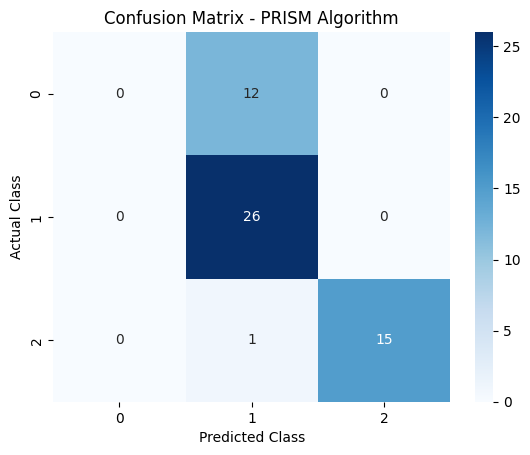

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix - PRISM Algorithm')
plt.show()


1. Which class is predicted best?
- The best predicted class is Class 1, with 26 samples correctly classified and no misclassifications into other classes. This indicates that the PRISM rules for Class 1 (e.g., color_intensity = Low and alcohol = Low) are highly specific and accurate in identifying this wine type.<br><br>
2. Are there misclassifications?
- All Class 0 wines (12 samples) were misclassified as Class 1, meaning the model struggled to identify the unique features of Class 0 wines. The possible reason is Class 0 and Class 1 share similar flavanoid or proline ranges, leading to overlapping rule conditions.
- For Class 2, there was 1 misclassification into Class 1, but most (15) were correctly predicted, showing good performance for this class.

In [23]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred))

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.67      1.00      0.80        26
           2       1.00      0.94      0.97        16

    accuracy                           0.76        54
   macro avg       0.56      0.65      0.59        54
weighted avg       0.62      0.76      0.67        54



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1. Which class is predicted best?
- Class 2 is predicted the best overall, with precision = 1.00 and recall = 0.94, meaning the model almost perfectly identifies this class.
- Class 1 also performs strongly (recall = 1.00, meaning all actual Class 1 samples were correctly classified).
- The PRISM rules for Class 1 and Class 2 are therefore both accurate and specific.<br><br>

2. Are there misclassifications?
- Class 0 has precision and recall = 0, meaning the model failed to correctly predict any samples for this class, all were misclassified as Class 1 (as seen in the confusion matrix).
- This shows that the rule coverage for Class 0 was weak or possibly overlapped heavily with Class 1.

<h2>Predict New Data Points

In [24]:
# Create new data points for the Wine dataset
# You can change these values to test different scenarios
new_wine_data = {
  'alcohol': [14.0, 14.00],
  'malic_acid': [2.0, 2.0],
  'ash': [2.3, 2.2],
  'alcalinity_of_ash': [19.0, 11.0],
  'magnesium': [95.0, 95.0],
  'total_phenols': [2.2, 2.5],
  'flavanoids': [0.14, 0.5],
  'nonflavanoid_phenols': [0.14, 0.5],
  'proanthocyanins': [1.6, 1.5],
  'color_intensity': [7.0, 6.0],
  'hue': [0.7, 0.6],
  'od280/od315_of_diluted_wines': [3.2, 3.0],
  'proline': [550.0, 1400.0]

}

new_wine_df = pd.DataFrame(new_wine_data)

# Predict on the new Wine data using the prism model trained on Wine data
wine_prediction = prism.predict(new_wine_df)
# Assign predictions to a new column in the DataFrame
new_wine_df['Predicted Class'] = wine_prediction

# Display the new data and prediction
print("New Wine Data Points:")
display(new_wine_df)

New Wine Data Points:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Predicted Class
0,14.0,2.0,2.3,19.0,95.0,2.2,0.14,0.14,1.6,7.0,0.7,3.2,550.0,1
1,14.0,2.0,2.2,11.0,95.0,2.5,0.50,0.50,1.5,6.0,0.6,3.0,1400.0,2


1. Which rule(s) applied to this data point?
- For the first data point, the data point aligned with the class 2 rule involving low flavanoids and medium color intensity; since it didnt meet the full conditions, no specific rule applied. For the second data point, the class 2 rule -> od280/od315 = Low AND color_intensity = High AND hue = Low, clearly applied, as the sample’s values fit this pattern closely.<br>
2. Why does PRISM classify it as that class?
- PRISM classified the first sample as class 1 because it failed to meet the full criteria of any high-confidence rule, so it defaulted to the next most likely class based on remaining data patterns. The second sample was classified as class 2 because it matched the strong, high support rule for that class, showing low od280/od315, high color intensity, and low hue — features characteristic of class 2 wines in the training data.